In [1]:
import sys
import subprocess
import os
from collections import defaultdict
import math
import re

from numba import jit
from numba.typed import List
from numba.typed import Dict
import numba


import random
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from sklearn.cluster import KMeans

In [2]:
def error(msg):
    print("*** ERROR ***\n", msg, "\n\n"); 
    input("Press Enter to continue...")
    sys.exit(0)

# Loading a .obj Model

In [3]:
def getint(str, linenb):
    """Parse an integer from str, abort on error
       - linenb the line number in the file in case of error"""
    try:
        v = int(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def getfloat(str, linenb):
    """Parse a float from str, abort on error
       - linenb the line number in the file in case of error"""
    try:
        v = float(str)
        return v
    except:
        error(f"cannot convert [{str}] to int at line {linenb + 1}")

def parseFaceTag(f, lena, linenb):
    """Parse a 'v/t/n' tag line in the obj file
       - lena = (nb_vertices, nb_textures, nb_normals) the current count of vertices/textures/normals
       - linenb the line number in the file in case of error"""
    x = f.split("/")
    #x = x[:1] # uncomment to remove texture and normals.     
    if len(x) == 0 or len(x) > 3:
        error(f"wrong face index: {f} at line {linenb+1}")
    if len(x) == 1:
        x += ['', '']
    if len(x) == 2:
        x += ['']            
    for i in range(3): 
        if x[i] == '':
            x[i] = -1
        else:
            v = getint(x[i], linenb)        
            if (v == 0):
                error(f"wrong face index: {f} at line {linenb+1} (index 0)")
            x[i] = (v - 1) if v > 0 else lena[i] + v                       
    return tuple(x)

def splitFace(face):
    """Convert a face [f1,f2,f3,..,fn] to a list of triangles [(f1,f2,f3), (f1,f3,f4), (f1,f4,f5),...]"""
    if (len(face) == 3):        
        return [tuple(face)]
    return [tuple(face[:3])] + splitFace([face[0]] + face[2:])

def rotateTriangleToMin(T):
    """
    Rotate a triangle ( (v0,t0,n0), (v1,t1,n1), (v2,t2,n2) ) so that it begins with the
    minimum value of the vi's 
    """
    m = min(T[0][0], T[1][0], T[2][0])
    if (m == T[0][0]):
        return T
    if (m == T[1][0]):
        return (T[1], T[2], T[0])
    if (m == T[2][0]):
        return (T[2], T[0], T[1])

In [4]:
def cleanup_vertices(vertice, list_obj, digit_round = 8):
    """
    Clean up the 'vertice' list by removing duplicate values and update the list of meshes 'list_obj' 
    """
    nbv = 0
    new_vertice = []
    dver = {}
    for obj in list_obj:
        for n in range(len(obj)):
            T = list(obj[n])
            for k in range(3):
                (jv, jt, jn) = T[k]
                V = np.round(vertice[jv], digit_round)
                tV = tuple(V)
                if tV not in dver: # first encounter with this vertex
                    dver[tV] = nbv
                    new_vertice.append(V)
                    nbv += 1
                T[k] = (dver[tV], jt, jn)
            obj[n] = tuple(T)
    vertice.clear()
    vertice += new_vertice

def cleanup_textures(texture, list_obj, digit_round = 8):
    """
    Clean up the 'vertice' list by removing duplicate values and update the list of meshes 'list_obj' 
    """    
    nbt = 0
    new_texture = []
    dtex = {}
    for obj in list_obj:
        for n in range(len(obj)):
            T = list(obj[n])
            for k in range(3):
                (jv, jt, jn) = T[k]
                if jt >= 0:
                    V = np.round(texture[jt], digit_round)
                    tV = tuple(V)
                    if tV not in dtex: # first encounter with this texture
                        dtex[tV] = nbt
                        new_texture.append(V)
                        nbt += 1
                    T[k] = (jv, dtex[tV], jn)
                else:
                    T[k] = (jv, -1, jn)                    
            obj[n] = tuple(T)
    texture.clear()
    texture += new_texture

def cleanup_normals(normal, list_obj, digit_round = 8):
    """
    Clean up the 'vertice' list by removing duplicate values and update the list of meshes 'list_obj' 
    """    
    nbn = 0
    new_normal = []
    dnor = {}
    for obj in list_obj:
        for n in range(len(obj)):
            T = list(obj[n])
            for k in range(3):
                (jv, jt, jn) = T[k]
                if jn >= 0:
                    V = np.round(normal[jn], digit_round)
                    tV = tuple(V)
                    if tV not in dnor: # first encounter with this normal
                        dnor[tV] = nbn
                        new_normal.append(V)
                        nbn += 1
                    T[k] = (jv, jt, dnor[tV])
                else:
                    T[k] = (jv, jt, -1)                    
            obj[n] = tuple(T)
    normal.clear()
    normal += new_normal

In [5]:
def loadObjFile(filename):    
    """
    Load an .obj file. Return (vertice, texture, normal, obj, tag)
    
    where
    - vertice : list of verticles (as 3D numpy vectors)
    - texture : list of texture coords (as 3D numpy vectors) may be empty
    - normal  : list of normals (as 3D numpy vectors) may be empty    
    - obj: list of object. Each one being a list of triangles indices
    - tag: list of names of each object
    """

    vertice = []
    texture = []
    normal = []
    obj = []
    tag = []
    
    currentobj = []
    currentname = ""
    currenttagline = 0
    currentnb = 0
    
    print(f"Reading file {filename}.\n")
    try:
        with open(filename, "r") as f:
            lines = list(f)
    except:
        error(f"Cannot open file [{filename}]")
        
    for linenb , line in enumerate(lines): 
        l = line.split()
        if len(l) == 0:
            l = [""] # dummy value
        if l[0] == 'v':
            v = tuple(float(v) for v in l[1:])[:3]
            if len(v) != 3:
                error(f"found wrong vertex [v] (not 3 components) at line {linenb+1}")
            vertice.append(np.array(v, dtype=float))
            
        if l[0] == "vt":
            vt = tuple(float(t) for t in l[1:])[:2]
            if len(vt) != 2:
                error(f"found wrong texture coord [vt] (not 2 components) at line {linenb+1}")
            texture.append(np.array(vt, dtype=float))
           
        if l[0] == "vn":
            vn = tuple(float(n) for n in l[1:])[:3]
            if len(vn) != 3:
                error(f"found wrong normal [vn] (not 3 components) at line {linenb+1}")
            normal.append(np.array(vn, dtype=float))
            
        if l[0] == "o" or l[0] == "g" or l[0] == "usemtl":
            if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)
                currentobj = [] 
                currentname = "" if len(l) == 1 else " ".join(l)
                currenttagline = linenb
            else:
                currenttagline = linenb
                if len(l) >1:
                    currentname += " | " + " ".join(l)
                              
        if l[0] == 'f':
            face = [parseFaceTag(x , [len(vertice), len(texture), len(normal)], linenb) for x in l[1:]]
            currentobj += splitFace(face)
            
    if len(currentobj) > 0:                
                print(f"--- found object {len(obj)+1} starting from tag [{currentname}] at line {currenttagline+1} with {len(currentobj)} triangles.")
                obj.append(currentobj)
                tag.append(currentname)              
                
    if (len(obj) == 0):
        error("no faces found in the file !")

    setvi = set()
    setti = set()
    setni = set() 
    for o in obj:
        for T in o:
            for (v,t,n) in T:
                
                if v < 0:
                    error(f"negative vertex index {v} found in face {T}")
                if v >= len(vertice):
                    error(f"vertex index out of bound {v}/{len(vertice)} in face {T}")   
                setvi.add(v)
                
                if (t < -1) or (t >= len(texture)):
                    error(f"texture index out of bound {v}/{len(texture)} in face {T}")  
                setti.add(t)
                
                if (n < -1) or (n >= len(normal)):
                    error(f"normal index out of bound {v}/{len(normal)} in face {T}")  
                setni.add(n)
                
        for i in range(len(o)):
            o[i] = rotateTriangleToMin(o[i])

    if len(setti) > 1 and -1 in setti:
        error(f"Missing texture indexes for some faces (but not all).")  

    if len(setni) > 1 and -1 in setni:
        error(f"Missing normal indexes for some faces (but not all).")  

    cleanup_vertices(vertice, obj)
    cleanup_textures(texture, obj)
    cleanup_normals(normal, obj)

    print(f"\nTOTAL :")
    print(f"- {len(vertice)} vertices [v]")        
    print(f"- {len(texture)} texture coords [vt]")
    print(f"- {len(normal)} normals [vn]\n")

    return vertice, texture, normal, obj, tag

# Displaying meshes and meshlets in 3D

In [82]:
camera_pos = np.array([-1.5, -1.5, -1.5])

def display3D(list_obj, vertices):
    """
    display a list of mesahes, all sharing the same vertex set 'vertices'.
    Each mesh is displayed with a different color
    """
    # x,y,z arrays for the vertices coords.
    x = np.array([v[0] for v in vertices])
    y = np.array([v[1] for v in vertices])
    z = np.array([v[2] for v in vertices])

    i = []
    j = []
    k = []
    colors = []
    palette = px.colors.qualitative.Dark24
    for n, obj in enumerate(list_obj): 
        colors += [palette[n % 24] for _ in obj]
        i += [u[0][0] for u in obj]
        j += [u[1][0] for u in obj]
        k += [u[2][0] for u in obj]


    camera = dict(up=dict(x=0,y=0,z=1), center=dict(x=0,y=0,z=0), eye=dict(x=camera_pos[0], y=camera_pos[1], z=camera_pos[2]))
     
    fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1,facecolor=colors)] + [go.Scatter3d( x=np.array([-1.0,-1.0, -1.0, -1.0, +1.0, +1.0, +1.0, +1.0]), y=np.array([-1.0,-1.0, +1.0, +1.0, -1.0, -1.0, +1.0, +1.0]), z=np.array([-1.0, +1.0, -1.0, +1.0, -1.0, +1.0, -1.0, +1.0]), mode='markers')])
    #fig = go.Figure(data=[go.Mesh3d(x=x, y=y, z=z, i=i, j=j, k=k, opacity=1)])
    fig.update_layout(scene_camera=camera, scene = dict(xaxis = dict(nticks=10, range=[-1,1],), yaxis = dict(nticks=10, range=[-1,1],), zaxis = dict(nticks=10, range=[-1,1])), autosize=False, width=800, height=800)
    
    
    fig.show()

In [143]:
def displayMeshlets(obj, vertices, ind_m, cones):
    """
    Visualize the meshlets
    """
    obj_meshlets = [ [obj[n] for n in  im] for im in ind_m]

#    for nn in ind_meshlets:
#        R = splitConnected(obj, nn)
#        tot = np.sum([len(a) for a in R])
#        print(len(nn), " vertices splited in ",len(R)," component for a total of ", tot," triangle")
    
    camera = camera_pos
    vis = []
    disp = 0
    tot = 0
    for n in range(len(obj_meshlets)):
        U = normVec(camera - boundingBoxCenter(cones[n][2]))
        if (np.dot(cones[n][0], U) > (cones[n][1] - 1)*1.01):
            vis.append(obj_meshlets[n])
            disp += len(obj_meshlets[n])
        tot += len(obj_meshlets[n])

    print("showing ", len(vis), "/", len(obj_meshlets), " meshes for ", disp, "/", tot," = ", 100*(disp/tot))
    display3D(vis, vertices)    


# Bounding boxes

In [64]:
def findBoundingBox(vertices):
    """
    Find the minimum bounding box of a list of vertices
    """
    xmin , ymin, zmin  = vertices[0]
    xmax , ymax, zmax  = vertices[0]
    for (x,y,z) in vertices:
        xmin = min(xmin,x)
        xmax = max(xmax,x)
        ymin = min(ymin,y)
        ymax = max(ymax,y)
        zmin = min(zmin,z)
        zmax = max(zmax,z)        
    return np.array([xmin,ymin,zmin],dtype=float) , np.array([xmax,ymax,zmax],dtype=float)


def findMeshletBoundingBox(vertices, obj, indT):
    """
    Compute the bounding box for a sub-mesh of triangles
    """
    xmin , ymin, zmin  = vertices[obj[indT[0]][0][0]]
    xmax , ymax, zmax  = vertices[obj[indT[0]][0][0]]
    for k in indT:
        for i in range(3):
            (x,y,z) = vertices[obj[k][i][0]]
            xmin = min(xmin,x)
            xmax = max(xmax,x)
            ymin = min(ymin,y)
            ymax = max(ymax,y)
            zmin = min(zmin,z)
            zmax = max(zmax,z)        
    return np.array([xmin,ymin,zmin],dtype=float) , np.array([xmax,ymax,zmax],dtype=float)  


def boundingBoxCenter(R):
    return (R[0] + R[1])/2


def recenterAndRescale(vertices, ask=True):
    """
    Recenter and rescale a list of vertices so that the bouding box fits in [-1,1]^3
    """
    pr = 2
    (xmin,ymin,zmin),(xmax,ymax,zmax) = findBoundingBox(vertices)    
    print(f"\nBounding box of the model [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]")
    ans = "y" if ask==False else input("Do you want to translate/resize the model to fit in [-1,1]^3 (y/N) ?")        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        cx = (xmin + xmax)/2
        cy = (ymin + ymax)/2
        cz = (zmin + zmax)/2
        mx = (xmax -xmin)/2
        my = (ymax -ymin)/2
        mz = (zmax -zmin)/2
        s = max(mx,my,mz)
        for i in range(len(vertices)):            
            x,y,z  = vertices[i]
            vertices[i] = np.array([(x - cx)/s , (y-cy)/s, (z-cz)/s], dtype=float)                    
        (xmin,ymin,zmin),(xmax,ymax,zmax) = findBoundingBox(vertices)        
    if len(ans) > 0 and (ans.lower())[0] == "y":        
        print(f"New bounding box [{round(xmin,pr)},{round(xmax,pr)}]x[{round(ymin,pr)},{round(ymax,pr)}]x[{round(zmin,pr)},{round(zmax,pr)}]\n")
    return vertices , (np.array([xmin,ymin,zmin],dtype=float) , np.array([xmax,ymax,zmax],dtype=float))

# Normals

In [37]:
def dist(A, B):
    """ Compute the euclidian distance beetween 2 vectors """
    V = A - B
    return np.sqrt(np.sum(V*V))

def norm(V):
    """ Return the norm of a vector """
    return np.sqrt(np.sum(V*V))    
    
def normVec(V):
    """ Return a normalized vector. Does nothing for 0 """
    norm = np.sqrt(np.sum(V*V))
    return V if (norm == 0) else V/norm

def crossProduct(VA,VB):
    """ Compute the cross product between two vectors """
    return np.cross(VA,VB)

def Vec(VA, VB):
    """ Construct a vector from 2 vertices """
    return VB - VA

In [38]:
def triangleNormalArray(obj, vertices):
    """
    Construct the array for the normal of each triangle in obj
    """
    Nr = np.zeros((len(obj),3), dtype=float)
    for n in range(len(obj)):
        T = obj[n]
        V1 = np.array(vertices[T[0][0]])
        V2 = np.array(vertices[T[1][0]])
        V3 = np.array(vertices[T[2][0]])
        sU = Vec(V1, V2)
        sV = Vec(V1, V3)
        N = crossProduct(sU,sV)
        N = normVec(N)
        Nr[n,:] = N
    return Nr

        
def createGouraudNormals(vertices, normal, obj, ask = True, force_regeneration = False):
    """
    Compute the "gouraud" normals if not already present or if force_regeneration = True
    """
    if force_regeneration:        
        normal = []
    if len(normal) == 0:                
        print("No normal found. ", end="")
        ans = "y" if ask==False else input("Do you want to compute smooth normals (y/n) ?")       
        if len(ans) > 0 and ((ans.lower())[0] == "y" or (ans.lower())[0] == "o"):        
            # create the normals
            normal = [np.array([0.0, 0.0, 0.0], dtype=float)] * len(vertices)            
            for o in obj:
                for T0,T1,T2 in o:   
                    i0 = T0[0]
                    i1 = T1[0]
                    i2 = T2[0]
                    V0 = Vec(vertices[i1] , vertices[i0])
                    V1 = Vec(vertices[i2] , vertices[i1])
                    V2 = Vec(vertices[i0] , vertices[i2])
                    N0 = crossProduct(V2, V0)
                    N1 = crossProduct(V0, V1)
                    N2 = crossProduct(V1, V2)
                    N = N0 + N1 + N2                    
                    normal[i0] = normal[i0] + N
                    normal[i1] = normal[i1] + N
                    normal[i2] = normal[i2] + N                    
            # insert normal indexes in object
            for o in obj:
                for i in range(len(o)):                        
                    T1, T2, T3 = o[i]
                    o[i] = ((T1[0], T1[1], T1[0]),(T2[0], T2[1], T2[0]),(T3[0], T3[1], T3[0]))
        print(f"done.")

    # normalize the normals, even if we do not recompute them
    for i in range(len(normal)):
        normal[i] = normVec(normal[i])        
        n = norm(normal[i])
        if (n < 0.999) or (n > 1.001):
            print(f"error normal {normal[i]} (index {i}) with norm ={n}")
    print(f"number of normals: {len(normal)}")
    return normal  

# Vector cones computation

In [39]:
@jit(nopython=True)
def dist(A, B):
    """ Compute the euclidian distance beetween 2 vectors """
    V = A - B
    return np.sqrt(np.sum(V*V))

@jit(nopython=True)
def normVec(V):
    """ Return a normalized vector. Does nothing for 0 """
    norm = np.sqrt(np.sum(V*V))
    return V if (norm == 0) else V/norm

@jit(nopython=True)
def crossProduct(VA,VB):
    """ Compute the cross product between two vectors """
    return np.cross(VA,VB)

@jit(nopython=True)
def Vec(VA, VB):
    """ Construct a vector from 2 vertices """
    return VB - VA

In [40]:
@jit(nopython=True)
def cosToAngle(a):
    """convert from cosine to angle in degrees"""
    return np.arccos(a)*180/np.pi


@jit(nopython=True)
def angleToCos(deg):
    """convert from angle in degrees to cosine"""
    return np.cos(deg*np.pi/180)


# library used to construct the array: 'pip install icosphere'
# from icosphere import icosphere
# A, _ = icosphere(2)
# improveCone_vico = A.T
improveCone_vico = np.array([[ 0.        ,  0.        ,  0.52573111, -0.52573111,  0.85065081, -0.85065081, -0.        , -0.        , -0.52573111,  0.52573111, -0.85065081,  0.85065081,  0.        ,  0.30901699, -0.30901699, 0.5       , -0.5       ,  0.5       , -0.5       , -0.30901699, 0.30901699,  0.        ,  0.80901699,  0.30901699,  0.80901699, -0.80901699, -0.30901699, -0.80901699,  0.80901699,  1.        , -0.80901699, -1.        , -0.        , -0.30901699,  0.30901699, -0.5       ,  0.5       , -0.5       ,  0.5       ,  0.        , -0.80901699,  0.80901699],
       [ 0.52573111, -0.52573111,  0.85065081,  0.85065081,  0.        , 0.        , -0.52573111,  0.52573111, -0.85065081, -0.85065081, -0.        , -0.        ,  0.        ,  0.80901699,  0.80901699, 0.30901699,  0.30901699, -0.30901699, -0.30901699, -0.80901699, -0.80901699,  1.        ,  0.5       ,  0.80901699,  0.5       , 0.5       ,  0.80901699,  0.5       , -0.5       ,  0.        , -0.5       ,  0.        ,  0.        , -0.80901699, -0.80901699, -0.30901699, -0.30901699,  0.30901699,  0.30901699, -1.        , -0.5       , -0.5       ],
       [ 0.85065081,  0.85065081,  0.        ,  0.        ,  0.52573111, 0.52573111, -0.85065081, -0.85065081, -0.        , -0.        , -0.52573111, -0.52573111,  1.        ,  0.5       ,  0.5       , 0.80901699,  0.80901699,  0.80901699,  0.80901699,  0.5       , 0.5       ,  0.        ,  0.30901699, -0.5       , -0.30901699, 0.30901699, -0.5       , -0.30901699,  0.30901699,  0.        , 0.30901699,  0.        , -1.        , -0.5       , -0.5       , -0.80901699, -0.80901699, -0.80901699, -0.80901699, -0.        , -0.30901699, -0.30901699]])


@jit(nopython=True)
def findCone(normals, ind, tentative_center = None, eps_start = 0.1, eps_stop = 0.001):
    """
    Find the best bounding cone for a subset of normal vectors. 
    input:
    - normals : array of normal vectors 
    - ind : list of indices of the set of normal vectors to consider for the bounding cone
    return (center, a) where 
    - center : center vector of the cone
    - a : max cosine value for all the angles between the center vector and the subset of normals 
    """

    # create the matrix of normals
    L = len(ind)    
            
    if L == 1:
        return (normVec(normals[ind[0]]), 1.0)
    
    N = np.zeros((L,3), dtype=float)
    for k in range(L):
        N[k,:] = normVec(normals[ind[k]])

    # initial center
    if (tentative_center is not None):
        center = tentative_center # use provided tentative_center (must be normalized)
    else:
        center = normVec(np.sum(N, axis=0)) # start with the barycenter

    a = np.min(N.dot(center)) # compute the min cosine angle between the center and the normals
    
    eps =eps_start
    D = improveCone_vico.shape[1] # number of directions to test
    scaling = eps * np.arccos(a) # scaling factor
    
    while(1):        
        # compute the D tentative new centers
        C = center.reshape(3,1) + (scaling * improveCone_vico) # vector of position        
        C /= np.sqrt(np.sum(C*C, axis=0)).reshape(1,D) # normalize it
        
        # make the dot product with all the normals and take the min value among all normals for each tentative center
        A = N.dot(C)
        
        # find the index i and cosine angle ma of the best tentative center
        i = 0
        ma = -2
        for j in range(D):
            aa = np.min(A[:,j])
            if (aa > ma):
                ma = aa
                i = j
        
        if (ma <= a):
            # no improvement
            if (eps <= eps_stop):
                #print(f"end angle ={np.arccos(a) * 180 / np.pi} \t center={center}") 
                return (center, a)
            eps /= 2
            scaling = eps * np.arccos(a) # scaling factor
            #print(f"new eps {eps}")
        else:
            # update center and cosine angle        
            center = C[:, i].copy()
            a = ma
            #print(f"  imp: a={a} \t center={center}") 


# Creating meshlets

In [41]:
def createMeshlets(obj, vertices, alpha=1.0, beta=1.0):
    """
    Split a mesh (ie a list of triangles) 'obj' with vertex set 'vertices'.
    Other parameters:
        - alpha : coefficient for the importance of normals vs positions
        - beta : factor in front of sqrt(N) for the number of meshlets

    Return
        - a list of list of indices representing the meshlet and a list of  
        - a list of (C,a) where 'C' is the center vector of the cone and 'a' the cosine of the angle for the
          visibility cone associated with a meshlet
    """
    # x,y,z arrays for the vertices coords.
    x = [v[0] for v in vertices]
    y = [v[1] for v in vertices]
    z = [v[2] for v in vertices]

    # i, j, k arrays for the indices of the triangles
    i = [u[0][0] for u in obj]
    j = [u[1][0] for u in obj]
    k = [u[2][0] for u in obj]

    # construct the array of normals
    Nr = triangleNormalArray(obj, vertices)

    # position in space R^3 x R^3 of the triangles (input for k-means)
    center = np.array([[(x[i[n]] + x[j[n]] + x[k[n]])/3 , (y[i[n]] + y[j[n]] + y[k[n]])/3, (z[i[n]] + z[j[n]] + z[k[n]])/3, alpha*Nr[n][0], alpha*Nr[n][1], alpha*Nr[n][2] ]  for n in range(len(obj))])

    # perform k-means clustering
    nbclusters = int(beta*np.sqrt(len(obj)))
    print("Splitting the mesh object in ", nbclusters, " meshlets... ")
    kmeans = KMeans(n_clusters=nbclusters, n_init=10, random_state=1)
    kmeans.fit(center)

    # collect the meshlet in a list of list of triangle indices.
    ind_meshlets = [ [] for _ in range(nbclusters) ]
    for n in range(len(obj)):   
        ind_meshlets[kmeans.labels_[n]].append(n)

    print("done !");

    # create the associated list of (C,a) where C is the  cone center vector and a the cosine angle
    # for the bounding cone of all normal vectors of the triangles in a meshlet
    cones = []
    for  k, M in enumerate(ind_meshlets):
        C, ma = findCone(Nr, M)
        R = findMeshletBoundingBox(vertices, obj, M)
        cones.append((C,ma, R))        
        print(f"meshlet [{k}] with {len(M)} triangles and visibility angle {cosToAngle(ma):.2f} deg")
     

    # return the meshlet (as list of list of indices in obj) and the associated list of visibility cones
    return ind_meshlets, cones

# Smoothing meshlets

In [42]:
@jit(nopython=True)
def createAdjDic_jit(obj, indT):
    """
    Create a dictionary of triangle adjacency. Return D where
    D[i] is a list of all indices j such that obj[j] is adjacent to obj[i]
    """
    # create a map from edges to triangles indices
    E = {}
    for n in indT:
        T = obj[n]
        if (T[0], T[1]) not in E:
            E[(T[0], T[1])] = List([n])
        else:
            E[(T[0], T[1])].append(n)        
        
        if (T[1], T[2]) not in E:
            E[(T[1], T[2])] = List([n])
        else:
            E[(T[1], T[2])].append(n)
        
        if (T[2], T[0]) not in E:
            E[(T[2], T[0])] = List([n])
        else:
            E[(T[2], T[0])].append(n)
            
    # now create adjacency dic
    D = { 0 : np.array([1]) }
    D.clear()

    for n in indT:
        T = obj[n]
        L = [0]
        L.remove(0)
        if (T[1],T[0]) in E: L+= list(E[(T[1],T[0])])
        if (T[2],T[1]) in E: L+= list(E[(T[2],T[1])])
        if (T[0],T[2]) in E: L+= list(E[(T[0],T[2])])            
        D[n] = np.array(L) # convert to np array for speed.    
    return D


@jit(nopython=True)
def DAN(MI, DD, n, mi):
    """Return a list of all indices which are neighbour of n
        and below gto meshlet mi"""
    return [k for k in DD[n] if (MI[k] == mi)]


@jit(nopython=True)
def int_degT(MI, DD, n):
    """return the degree of a triangle inside its own meshlet"""
    return len(DAN(MI, DD, n, MI[n]))


In [43]:
def smooth_meshlets(obj, vertices, ind_mesh, cones, angle_threshold = 0.1, angle_discount = 0.001):
    
    Nr = triangleNormalArray(obj, vertices)

    obj = List(x for x in obj) 
    vertices = np.array(vertices)
    ind_mesh = List(List(x) for x in ind_mesh)
    cones = List(x for x in cones)

    ind_new = smooth_meshlets_jit(obj, vertices, ind_mesh, cones, angle_threshold, angle_discount)

    cones = []
    ind_res = []
    k = 0
    for  m in ind_new:
        M = list(m)
        if (len(M) > 0):
            C, ma = findCone(Nr, M)
            R = findMeshletBoundingBox(vertices, obj, M)
            cones.append((C,ma, R))
            ind_res.append(M)
            print(f"meshlet [{k}] with {len(M)} triangles and visibility angle {cosToAngle(ma):.2f} deg")
            k+=1
        
    return (ind_res,cones)

@jit(nopython=True)
def smooth_meshlets_jit(obj, vertices, ind_mesh, cones, angle_threshold, angle_discount):
    """
    Apply smoothing to the meshlets
    - ind_mesh: list of list of indices of triangles that describe the meshlets
    - cones : cone: list of pair (C,a) where C is the center vector and a the cosine for the angle of the ocne that obunds the meshlet with same index. 
    - obj : list of triangles
    - Nr :list of normal vectors associated with the triangles
    """

    print("Smoothing meshlets...")
     
    # create a list of all indices 
    nbi = 0 # total number of indices
    for sm in ind_mesh:
        nbi += len(sm)
    all_indices = np.zeros((nbi,),dtype=np.int64)
    dA = all_indices.copy()

    k = 0
    for sm in ind_mesh:
        for x in sm:
            all_indices[k] = x
            k+=1
    
    # construct the array of normals\n",
    Nr = np.zeros((len(obj),3), dtype=float)
    for n in range(len(obj)):
        T = obj[n]
        V1 = vertices[(T[0][0])]
        V2 = vertices[(T[1][0])]
        V3 = vertices[(T[2][0])]
        sU = Vec(V1, V2)
        sV = Vec(V1, V3)
        N = crossProduct(sU,sV)
        N = normVec(N)
        Nr[n,:] = N
      
    print("Initialization")
    # create the full adjacency dic
    DA = createAdjDic_jit(obj, all_indices)

    # dictionary that maps a triangle to its meshlet index
    MeshInd = {}
    for n, sm in enumerate(ind_mesh):
        for p in sm:
            MeshInd[p] = n

    
    round = 0
    move = 0    
    accept_equal_round_max = 3
    accept_equal_round = 0
    accept_equal = False
   
    while True:
        round += 1
        print("- round ", round)

        A = all_indices.copy()
        for k in range(len(A)):
            dA[k] = int_degT(MeshInd, DA, A[k]) + (2*len(ind_mesh[MeshInd[A[k]]]))
        ind = np.argsort(dA)
        for k in range(len(A)):
            all_indices[k] = A[ind[k]]

        improved = False # no improvement found so far

        for x in all_indices:           
            # we iterate over all vertices (starting with those with smallest inner degree). 

            
            xmi = MeshInd[x] # index of the current meshlet for x    
            Mnei = set() # create set of meshlets adjacent to x

            for k in DA[x]:
                Mnei.add(MeshInd[k])
            bestmi = -1
            bestdelta = -1 if (accept_equal) else 0
            
            for ymi in Mnei:
                if ymi != xmi:
                    # we may try changing x from meshlet xmi to ymi
                    d_x_ymi = DAN(MeshInd, DA, x, ymi)
                    d_x_xmi = DAN(MeshInd, DA, x, xmi) 

                    delta = len(d_x_ymi) - len(d_x_xmi) # difference of degree of x in the new meshlet vs the current one                    
                    delta += len([1 for z in d_x_ymi if (int_degT(MeshInd, DA, z) < 2)]) - len([1 for z in d_x_xmi if (int_degT(MeshInd, DA, z) < 3)]) # difference for neighours in xmi and ymi
                                            
                    if (delta > bestdelta):
                        # check if we stay below the conne threshold
                        a = cones[ymi][1]
                        ind_mesh[ymi].append(x) # add x for computing the cone
                        c, new_a = findCone(Nr, ind_mesh[ymi], tentative_center = cones[ymi][0])
                        ind_mesh[ymi].pop() # remove x
                        a = cosToAngle(a)
                        new_a = cosToAngle(new_a)
                        if ((delta > 0) and (new_a - a < angle_threshold*a)) or (new_a - a < angle_discount*a):
                            bestdelta = delta
                            bestmi = ymi                           
            if (bestmi != -1):
                # ok, we can perform the swap
                if (bestdelta > 0): improved = True # strict improvement
                move += 1
                # update ind_mesh
                ind_mesh[xmi].remove(x)
                ind_mesh[bestmi].append(x)
                # update meshInd
                MeshInd[x] = bestmi                                
                #print(f"-> moved {x} form meshlet {xmi} to meshlet {bestmi}")               
        if not improved:
            if (accept_equal == False):                
                accept_equal = True
                accept_equal_round = 0
            else:
                accept_equal_round += 1
                if (accept_equal_round >= accept_equal_round_max):                
                    print(" done !", move, "moves performed in ", round, "passes.")            
                    return ind_mesh
        else:
            accept_equal = False
            accept_equal_round = 0            

# Merging connected components

In [44]:
def SplitConnectedMeshlets(obj, vertices, ind_mesh, cones):
    
    Nr = triangleNormalArray(obj, vertices)
    mesh_list = []
    cone_list = []
    tot = 0
    for k, mesh in enumerate(ind_mesh):
        comp = splitConnected(obj, mesh)
        print(f"\n- meshlet {k} with {len(mesh)} triangles splitted in {len(comp)} components: ", end="")
        for M in comp:
            tot+=1
            C, ma = findCone(Nr, M)
            R = findMeshletBoundingBox(vertices, obj, M)
            mesh_list.append(M)
            cone_list.append((C,ma, R))        
            print(f"[{len(M)} a={cosToAngle(ma):.2f}] ",end="")
    print(f"\nTotal number of connected meshlets: {tot}")
    return mesh_list, cone_list
            

In [45]:
def createAdjDic(obj, indT):
    """
    Create a dictionary of tirangle adjacency. Return D where
    D[i] is a list of all indices j such that obj[j] is adjacent to obj[i]
    """
    # create a map from edges to triangles indices
    E = defaultdict(lambda: [])
    for n in indT:
        T = obj[n]
        E[(T[0], T[1])].append(n)
        E[(T[1], T[2])].append(n)
        E[(T[2], T[0])].append(n)
    # now create adjacency dic
    D = defaultdict(lambda: [])
    for n in indT:
        T = obj[n]
        D[n] = E[(T[1],T[0])] + E[(T[2],T[1])] + E[(T[0],T[2])]
        D[n] = np.array(D[n], dtype=np.int64) # convert to np array for speed.    
    return D


def splitConnected(obj, indT):
    """
    split a list 'indT' of triangles indices of 'obj' into a list of list of triangle indices
    where each sublist is a connected set.
    Use greedy exploration
    """
    L = len(indT)
    DA = dict(createAdjDic(obj, indT))
    res = []

    remaining = set(indT) # set of indices not yet classified
    while remaining:
        active = [remaining.pop()] # list of active vertices
        explored = [] # list of explored vertices
        while(active):
            x = active.pop()
            explored.append(x)
            for y in DA[x]:
                if y in remaining:
                    remaining.remove(y)
                    active.append(y)
        res.append(explored) # add the connected component
    return res                

In [46]:
def mergeMeshlets(obj, vertices, ind_meshlets, angle_threshold_inc = 0.1, angle_maxmerge = 30):

    ind_mesh = [ m.copy() for m in ind_meshlets] # make a deep copy

    # adjacency dic between triangles
    adj = dict(createAdjDic(obj, list(range(len(obj))))) 

    # dictionary that maps a triangle index to its meshlet index
    MeshInd = {}
    for n, sm in enumerate(ind_mesh):
        for p in sm:
            MeshInd[p] = n

    # adjacency dict between meshlets indices
    DAN = defaultdict(lambda: set())
    for P, sm in enumerate(ind_mesh):
        for p in sm:
            for q in adj[p]:
                Q = MeshInd[q]
                if P != Q:
                    DAN[P].add(Q)
                    DAN[Q].add(P)    

    # compute the initial cone angles
    cones = []
    Nr = triangleNormalArray(obj, vertices)
    for k, M in enumerate(ind_mesh):
        V, a = findCone(Nr, M)
        cones.append((V,cosToAngle(a)))
        #print(f"meshlet {k} with size {len(M)} and angle {cones[k][1]}")
        
    print("starting merging meshlets...")
    
    continue_merging = True
    while continue_merging:
        continue_merging = False
        # sort meshlets indices by increasing meshlet size
        ind = np.argsort([len(m) for m in ind_mesh])
        # iterate over all meshlets
        for mj in ind:

            if len(ind_mesh[mj]) > 0:
                # ok, got a non empty meshlet: look if we can merge it with a neighbour
                bestmi = -1
                bestval = 0
                bestV = None
                besta = None
                sai = None
                Vj, aj = cones[mj] # vector and angle for cone of meshlet mj
                for mi in DAN[mj]:
                    if (mi != mj) and (len(ind_mesh[mi]) > 0):
                        Vi, ai = cones[mi] # vector and angle for cone of meshlet mi
                        # compute center and angle of the merging
                        newV, newa = findCone(Nr, ind_mesh[mi] + ind_mesh[mj], tentative_center = normVec(cones[mi][0] + cones[mi][0]))
                        newa = cosToAngle(newa)
                        maij = max(ai, aj)
                        if newa  <= max((1.0 + angle_threshold_inc)*max(ai, aj), angle_maxmerge):
                            # ok, merging is admissible
                            val = 1.0/len(ind_mesh[mi]) # give priority to small meshes
                            if (val > bestval):
                                sai = ai
                                bestval = val
                                bestmi = mi
                                bestV = newV
                                besta = newa
                
                if bestmi != -1:
                    # ok, we perform merging of meshlet mj and bestmi 
                    mi = bestmi                    
                    print(f"merging meshlet {mj} of size {len(ind_m[mj])} and angle {aj} with meshlet {mi} of size {len(ind_m[mi])} and angle {sai} -> new angle {besta}")

                    if (aj > ai): mi, mj = mj, mi # we keep the meshlet with the largest angle
                    #perform merging in DAN and ind_mesh
                    if mj in DAN[mj]: DAN[mj].remove(mj)
                    for m in DAN[mj]:
                        DAN[m].remove(mj)
                        DAN[m].add(mi)
                        DAN[mi].add(m)
                    if mi in DAN[mi]: DAN[mi].remove(mi)
                    if mj in DAN[mi]: DAN[mi].remove(mj)
                    DAN[mj].clear()
                    ind_mesh[mi] += ind_mesh[mj]
                    ind_mesh[mj].clear()
                    
                    cones[mi] = (bestV, cones[mi][1]) # update the center of the new meshlet cone but not its angle ! 
                    continue_merging = True

    ind_m2 = [m for m in ind_mesh if len(m) > 0]
    cones = []
    for M in ind_m2:
        C, ma = findCone(Nr, M)
        R = findMeshletBoundingBox(vertices, obj, M)
        cones.append((C,ma, R))

    print(f"finale number of meshlet: {len(ind_m2)}")
    return ind_m2, cones



# Stripification

In [47]:
def stripifyLKH(mesh):
    """
    Stripify a mesh
    - take as input a list of triangles 
    - return a list of list of triangle with each sublist being a strip with triangle correctly rotated. 
    """
    IndexToTriangle = mesh
    L = len(IndexToTriangle)

    DA = dict(createAdjDic(IndexToTriangle, list(range(L))))
    
    def isAdjacent(T1, T2):
        """Check if T2 is adjacent to T1"""
        E1 = { (T1[0], T1[1]) , (T1[1], T1[2]), (T1[2], T1[0])}
        E2 = { (T2[0], T2[2]) , (T2[2], T2[1]), (T2[1], T2[0])}
        return (len(E1.intersection(E2)) > 0)

    def rotateTriangleStartVertex(T,V):
        """Rotate a triangle T=(V1, V2, V3) so that it starts with a given vertex V"""
        if V == T[0]:
            return T
        if V == T[1]:
            return (T[1], T[2], T[0])
        if V == T[2]:
            return (T[2], T[0], T[1])
        error(f"error in rotateTriangleStartVertex({T} , {V}), vertex not found")   

    if (L > 2): # for mesh with more than 2 vertices, we use LKH to find a near optimal tour.        
        with open("meshlet.par", "w") as f:
            f.write(f"PROBLEM_FILE = meshlet.tsp\n")
            f.write(f"MOVE_TYPE = 5\n")
            f.write(f"PATCHING_C = 3\n")
            f.write(f"PATCHING_A = 2\n")
            f.write(f"RUNS = 8\n")
            f.write(f"OUTPUT_TOUR_FILE = meshlet_res.txt\n")
    
        with open("meshlet.tsp","w") as f:
            f.write(f"NAME: test\n")
            f.write(f"TYPE: TSP\n")
            f.write(f"DIMENSION: {L}\n")
            f.write(f"EDGE_WEIGHT_TYPE: EXPLICIT\n")
            f.write(f"EDGE_WEIGHT_FORMAT: LOWER_DIAG_ROW\n")
            f.write(f"EDGE_WEIGHT_SECTION\n")
            for i in range(L):
                for j in range(i + 1):
                    f.write(("0" if j in DA[i] else "1") + " ")
                f.write("\n")
            f.write(f"EOF\n")

        if os.path.exists("meshlet_res.txt"):
            os.remove("meshlet_res.txt")

        print("Running LKH...", end="")
        out = subprocess.check_output(["LKH-2.exe", "meshlet.par"], shell=True)

        if not os.path.exists("meshlet_res.txt"):
            error(f"Error running LKH\n------------\n{out}")

        with open("meshlet_res.txt", "r") as f:
            lines = list(f)

        for n, l in enumerate(lines):
            if l.split()[0] == 'TOUR_SECTION':
                break
            
        tour = []
        for i in range(n + 1,len(lines) - 1):
            v = int(lines[i].split()[0])
            if v < 0: break
            tour.append(v - 1)

        for n in range(len(tour)):    
            tour[n] = IndexToTriangle[tour[n]]

    else: # mesh with 1 or 2 vertices has a trivial tour
        tour = [IndexToTriangle[i] for i in range(L)]

    for n in range(len(tour)-1):        
        if not isAdjacent(tour[n], tour[n+1]):
            tour = tour[(n + 1):] + tour[:(n + 1)]
            break

    sol = []
    cur = [tour[0]]
    for n in range(1,len(tour)):        
        if isAdjacent(tour[n-1], tour[n]):
            cur.append(tour[n])
        else:
            sol.append(cur)
            cur = [tour[n]]
    sol.append(cur)

    # iterate over all chains
    for chain in sol: 
        if (len(chain) > 1):
            if chain[0][2] not in chain[1]:        
                 chain[0] = (chain[0][1], chain[0][2], chain[0][0]) # rotate start of chain        
        for n in range(len(chain) - 1):    
            T1 = chain[n]
            T2 = chain[n+1]        
            # now T1[2] should be in T2. 
            if T1[0] in T2:             
                # V0, V2 commom
                chain[n+1] = rotateTriangleStartVertex(T2, T1[0])  # V0, V2, V'
            else: 
                # V1, V2 commom
                chain[n+1] = rotateTriangleStartVertex(T2, T1[2])  # V2 V1 V'        
          
    print(f" done ! Created {len(sol)} chains for {len(mesh)} triangles \t[{(float(len(sol))/len(mesh))*100:.1f}%]")            
    return sol

In [159]:
vert, tex, norm, list_obj, tag = loadObjFile("dragon.obj")
obj = list_obj[0]

Reading file dragon.obj.

--- found object 1 starting from tag [ | g root | usemtl Acier_-_SatinÃ©] at line 11399 with 23000 triangles.

TOTAL :
- 11392 vertices [v]
- 0 texture coords [vt]
- 0 normals [vn]



In [160]:
vert, B = recenterAndRescale(vert,ask = False)


Bounding box of the model [-2.39,2.07]x[-2.83,4.21]x[-4.71,5.27]
New bounding box [-0.45,0.45]x[-0.7,0.7]x[-1.0,1.0]



In [161]:
ind_m, cones = createMeshlets(obj, vert, alpha=0.1, beta=3)

Splitting the mesh object in  454  meshlets... 
done !
meshlet [0] with 41 triangles and visibility angle 24.13 deg
meshlet [1] with 37 triangles and visibility angle 61.72 deg
meshlet [2] with 52 triangles and visibility angle 40.52 deg
meshlet [3] with 59 triangles and visibility angle 31.36 deg
meshlet [4] with 98 triangles and visibility angle 69.37 deg
meshlet [5] with 50 triangles and visibility angle 38.72 deg
meshlet [6] with 9 triangles and visibility angle 44.01 deg
meshlet [7] with 57 triangles and visibility angle 42.33 deg
meshlet [8] with 57 triangles and visibility angle 23.30 deg
meshlet [9] with 56 triangles and visibility angle 53.57 deg
meshlet [10] with 42 triangles and visibility angle 32.29 deg
meshlet [11] with 63 triangles and visibility angle 40.00 deg
meshlet [12] with 73 triangles and visibility angle 47.05 deg
meshlet [13] with 59 triangles and visibility angle 48.78 deg
meshlet [14] with 57 triangles and visibility angle 56.65 deg
meshlet [15] with 39 trian

In [162]:
ind_m, cones = SplitConnectedMeshlets(obj, vert, ind_m, cones)


- meshlet 0 with 41 triangles splitted in 1 components: [41 a=24.13] 
- meshlet 1 with 37 triangles splitted in 1 components: [37 a=61.72] 
- meshlet 2 with 52 triangles splitted in 1 components: [52 a=40.52] 
- meshlet 3 with 59 triangles splitted in 1 components: [59 a=31.36] 
- meshlet 4 with 98 triangles splitted in 4 components: [71 a=58.65] [22 a=60.35] [1 a=0.00] [4 a=31.25] 
- meshlet 5 with 50 triangles splitted in 1 components: [50 a=38.72] 
- meshlet 6 with 9 triangles splitted in 3 components: [6 a=39.57] [2 a=16.47] [1 a=0.00] 
- meshlet 7 with 57 triangles splitted in 1 components: [57 a=42.33] 
- meshlet 8 with 57 triangles splitted in 1 components: [57 a=23.30] 
- meshlet 9 with 56 triangles splitted in 1 components: [56 a=53.57] 
- meshlet 10 with 42 triangles splitted in 2 components: [41 a=32.29] [1 a=0.00] 
- meshlet 11 with 63 triangles splitted in 2 components: [62 a=38.23] [1 a=0.00] 
- meshlet 12 with 73 triangles splitted in 3 components: [61 a=47.04] [7 a=13.

In [163]:
ind_m, cones = mergeMeshlets(obj, vert, ind_m,0.1,45)

starting merging meshlets...
merging meshlet 375 of size 1 and angle 0.0 with meshlet 563 of size 1 and angle 0.0 -> new angle 41.256009820042706
merging meshlet 755 of size 1 and angle 0.0 with meshlet 660 of size 1 and angle 0.0 -> new angle 24.16911269098621
merging meshlet 758 of size 1 and angle 0.0 with meshlet 424 of size 1 and angle 0.0 -> new angle 44.77215592095688
merging meshlet 366 of size 1 and angle 0.0 with meshlet 467 of size 1 and angle 0.0 -> new angle 41.62759525118765
merging meshlet 763 of size 1 and angle 0.0 with meshlet 45 of size 1 and angle 0.0 -> new angle 25.696773289407105
merging meshlet 358 of size 1 and angle 0.0 with meshlet 712 of size 25 and angle 47.99183412546734 -> new angle 47.99183412546735
merging meshlet 356 of size 1 and angle 0.0 with meshlet 173 of size 42 and angle 37.45067297040496 -> new angle 43.34448107942496
merging meshlet 376 of size 1 and angle 0.0 with meshlet 563 of size 1 and angle 0.0 -> new angle 41.65118270353158
merging mesh

In [164]:
S = []
for m in ind_m:
    S.append(len(m))
S.sort()
for l in S: print(l,end=" ")

1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 7 7 7 7 8 8 8 8 8 9 9 9 9 10 11 11 12 12 13 13 13 13 14 14 14 15 15 16 16 16 17 18 18 18 18 20 20 20 22 22 23 23 23 23 24 25 25 25 25 26 27 27 28 28 28 28 29 30 30 31 31 31 32 32 32 32 32 33 33 33 33 33 33 34 34 35 35 36 36 36 37 37 37 37 38 39 39 40 40 40 41 41 42 42 42 42 43 43 43 43 43 43 43 44 44 44 45 45 47 47 47 47 47 48 48 48 48 48 48 48 49 49 49 49 49 49 49 50 50 50 51 51 51 51 52 52 52 53 53 54 54 54 55 55 55 56 56 56 56 56 57 58 58 58 59 59 59 59 59 60 61 61 62 62 64 64 64 65 65 65 68 68 68 70 70 71 72 72 73 74 74 75 76 80 82 85 87 89 89 90 90 90 90 91 91 94 94 95 96 96 97 99 99 100 100 101 103 103 105 105 106 107 109 110 11

In [168]:
S = []
for m in ind_m:
    S.append(len(m))
S.sort()
print("nb meshlet = ", len(S))
for l in S: print(l,end=" ")


nb meshlet =  440
1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 7 7 7 7 7 7 7 8 8 8 8 9 9 9 9 10 10 10 10 12 12 12 13 13 13 14 14 14 15 15 15 15 16 17 17 17 18 18 19 21 21 21 22 22 22 23 23 23 24 25 25 25 26 27 27 27 27 27 27 27 28 29 29 29 29 30 30 30 31 31 32 32 32 33 33 33 34 34 34 34 35 35 35 35 36 36 37 38 38 38 38 38 39 40 40 40 41 41 41 41 41 42 42 42 42 43 43 43 43 43 44 44 44 44 45 45 45 46 46 46 46 47 47 47 48 48 48 48 49 49 49 49 49 50 50 50 50 50 50 50 51 51 51 52 52 54 54 54 55 55 55 56 56 56 57 58 58 59 59 59 60 61 61 61 62 62 62 63 63 63 64 64 65 65 66 66 69 71 71 72 73 74 74 75 77 77 81 82 83 83 87 87 87 88 91 92 93 93 93 93 95 96 96 97 97 99 99 100 101 101 102 104 105 106 110 110 111 111 11

In [166]:
#cones

In [167]:
ind_m, cones = smooth_meshlets(obj, vert, ind_m ,cones, 0.1, 0.01)

Smoothing meshlets...
Initialization
- round  1
- round  2
- round  3
- round  4
- round  5
- round  6
- round  7
- round  8
- round  9
- round  10
- round  11
- round  12
- round  13
- round  14
- round  15
 done ! 1939 moves performed in  15 passes.
meshlet [0] with 52 triangles and visibility angle 62.82 deg
meshlet [1] with 56 triangles and visibility angle 31.94 deg
meshlet [2] with 69 triangles and visibility angle 58.65 deg
meshlet [3] with 21 triangles and visibility angle 60.35 deg
meshlet [4] with 2 triangles and visibility angle 44.72 deg
meshlet [5] with 4 triangles and visibility angle 31.25 deg
meshlet [6] with 47 triangles and visibility angle 38.34 deg
meshlet [7] with 6 triangles and visibility angle 39.57 deg
meshlet [8] with 2 triangles and visibility angle 16.47 deg
meshlet [9] with 1 triangles and visibility angle 0.00 deg
meshlet [10] with 197 triangles and visibility angle 61.51 deg
meshlet [11] with 35 triangles and visibility angle 44.06 deg
meshlet [12] with 4

showing  252 / 440  meshes for  15664 / 23000  =  68.10434782608695


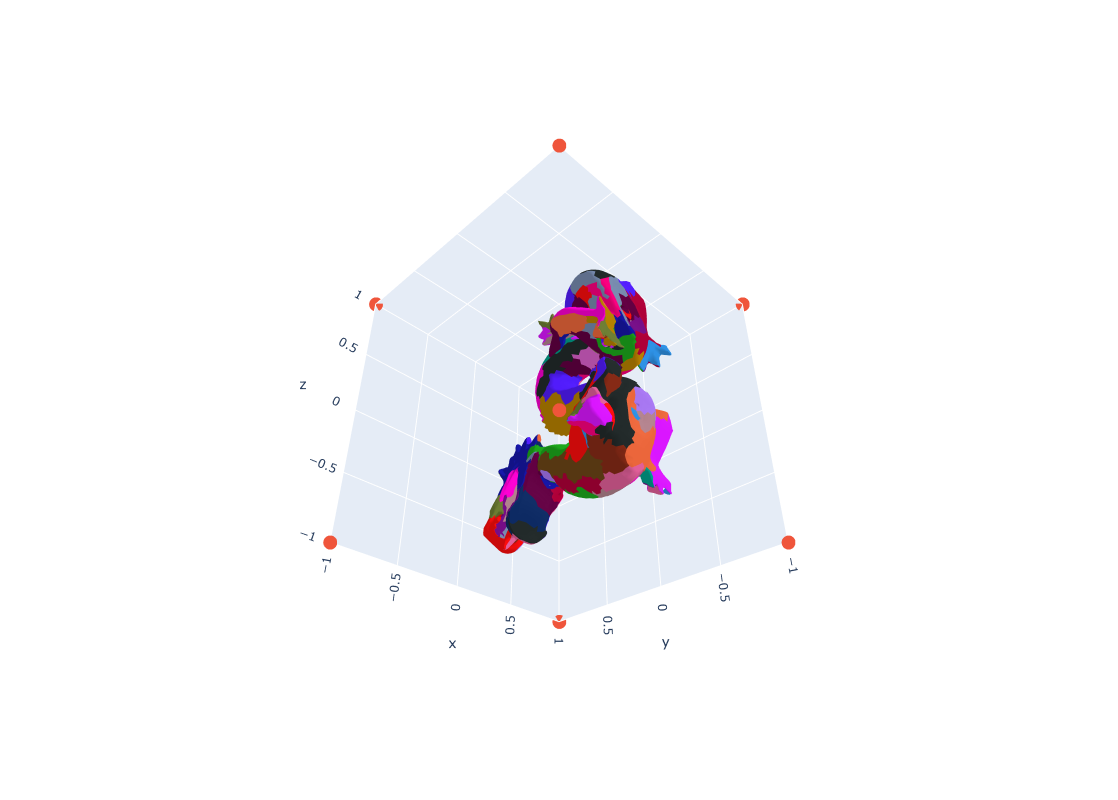

In [169]:
displayMeshlets(obj, vert, ind_m, cones)

In [171]:
obj_meshlets = [ [obj[n] for n in  im] for im in ind_m]

tot = 0
totT = 0
for m in obj_meshlets:
    r = stripifyLKH(m)
    tot += len(r)
    totT += len(m)
    
print(f"Total number of triangles:  {totT}")
print(f"Total number of chains:  {tot} \t [{(float(tot)/totT)*100:.1f}%]")

Running LKH... done ! Created 4 chains for 52 triangles 	[7.7%]
Running LKH... done ! Created 1 chains for 56 triangles 	[1.8%]
Running LKH... done ! Created 6 chains for 69 triangles 	[8.7%]
Running LKH... done ! Created 5 chains for 21 triangles 	[23.8%]
 done ! Created 1 chains for 2 triangles 	[50.0%]
Running LKH... done ! Created 1 chains for 4 triangles 	[25.0%]
Running LKH... done ! Created 1 chains for 47 triangles 	[2.1%]
Running LKH... done ! Created 2 chains for 6 triangles 	[33.3%]
 done ! Created 1 chains for 2 triangles 	[50.0%]
 done ! Created 1 chains for 1 triangles 	[100.0%]
Running LKH... done ! Created 5 chains for 197 triangles 	[2.5%]
Running LKH... done ! Created 1 chains for 35 triangles 	[2.9%]
Running LKH... done ! Created 2 chains for 49 triangles 	[4.1%]
Running LKH... done ! Created 2 chains for 35 triangles 	[5.7%]
Running LKH... done ! Created 1 chains for 49 triangles 	[2.0%]
Running LKH... done ! Created 1 chains for 7 triangles 	[14.3%]
Running LKH... 

KeyboardInterrupt: 

In [172]:
def invertEdge(E):
    """
    Invert the direction of an edge (V,W) -> (W,V)
    """
    return (E[1], E[0])

def edgeAfter(T , E):    
    """
    Return the next edge after E in T = (V1,V2,V3) with cyclic order
    """
    E1 = (T[0], T[1])
    E2 = (T[1], T[2])
    E3 = (T[2], T[0])
    if E == E1:
        return E2
    if E == E2:
        return E3
    if E == E3:
        return E1
    error(f"error in edgeAfter({T} , {E}), edge not found")

def edge(T, i):
    """
    Return edge number i in the triangle T = (V1, V2, V3)
    """
    return (T[0], T[1]) if i == 0 else ((T[1], T[2]) if i == 1 else ((T[2], T[0]) if i == 2 else error(f"error in edge({T} , {i}), incorrect i value")))

def rotateTriangleStartEdge(T,E):
    """
    Rotate a triangle T=(V1, V2, V3) so that it starts with a given edge E. 
    """
    if (T[0],T[1]) == E:
        return T
    if (T[1],T[2]) == E:
        return (T[1], T[2], T[0])
    if (T[2],T[0]) == E:
        return (T[2], T[0], T[1])
    error(f"error in rotateTriangleStartEdge({T} , {E}), edge not found")   


In [173]:
def reorderObjectTriangles(obj, strategy = 0):
    """
    Take an object (ie list of triangles) and return a list of chains. 
    """
    availT = obj[:] # list of triangles. Set to none once used. 
    dicedge = defaultdict(lambda: []) # mapping from edge to triangles indexes
    firstTavail = 0 # first triangle available in availT
    nbTavail = len(obj) # number of triangle available in availT
    for i in range(len(obj)):                
        dicedge[edge(obj[i],0)].append(i)
        dicedge[edge(obj[i],1)].append(i)
        dicedge[edge(obj[i],2)].append(i)   
    
    # this method return a triangle index a given edge and mark it as used
    # or return none if no triangle available. 
    def findTriangleWithEdge(E):
        nonlocal availT
        nonlocal dicedge
        nonlocal firstTavail
        nonlocal nbTavail
        L = dicedge[E]
        while(len(L) > 0):
            i = L.pop()
            if availT[i] != None:
                TT = availT[i]
                availT[i] = None
                nbTavail -= 1
                return TT
        return None

    # return the next available triangle or none if all triangles have been used
    def getNextTriangle():
        nonlocal availT
        nonlocal firstTavail
        nonlocal nbTavail        
        if nbTavail == 0:
            return None
        nbTavail -= 1
        while(availT[firstTavail] == None):
            firstTavail += 1            
        T = availT[firstTavail]
        availT[firstTavail] = None              
        return T
        
    R = []    
    inv = 0
    
    while True:        
        # start a new chain 
        T = getNextTriangle()
        if (T == None):
            return R        
        C = [ (None, T) ]        
        E = edge(T, 2) 
        
        while True:
            MAXCHAINLEN = 65535
            if len(C) == MAXCHAINLEN:                
                break    

            nE0 = E
            nE1 = edgeAfter(T, nE0)
            nE2 = edgeAfter(T, nE1)

            # possibly swap nE1 and nE2 depending of strategy
            if (strategy == 1): # other direction
                nE1, nE2 = nE2, nE1                  
            elif (strategy == 2): # alternate direction
                if inv == 0:
                    nE1, nE2 = nE2, nE1 
                inv = 1 - inv
            elif (strategy == 3): #random
                if (np.random.rand() < 0.5):
                    nE1, nE2 = nE2, nE1 
            
            E = nE1
            T2 = findTriangleWithEdge(invertEdge(nE1))
            if T2 == None:
                E = nE2
                T2 = findTriangleWithEdge(invertEdge(nE2))
                if T2 == None:
                    if len(C) > 1:                        
                        break 
                    else:
                        E = nE0
                        T2 = findTriangleWithEdge(invertEdge(nE0))
                        if T2 == None:                            
                            break 
                  
            # got the next link in T2 with shared edge E
            pT = C[-1][1]
            n = None
            if (E == (pT[0], pT[1])):
                if len(C) > 1:
                    error("wrong next edge...")
                n = 2
            if (E == (pT[2], pT[0])):
                n = 0
            if (E == (pT[1], pT[2])):
                n = 1
            if n == None:
                    error("edge not found...")        
            E = invertEdge(E)            
            T = T2
            C.append((n, rotateTriangleStartEdge(T,E)))
            
        if len(C)>1:
            if C[1][0] == 2:
                C[0] = (None , ( C[0][1][1], C[0][1][2], C[0][1][0] )) 
                C[1] = (0, C[1][1])
        R.append(C)

In [174]:
def nbCompute(C):
    tot = 0
    for u in C: 
        tot = tot + (2 + len(u))
    return tot
    
def stripify(ob, nbtry = 30):
    totmin = 4*len(ob)
    for i in range(nbtry):    
        if i > 3:
            random.shuffle(ob)    
        C = reorderObjectTriangles(ob, (i%4))
        tot  = nbCompute(C)
        if tot < totmin:
            totmin = tot
            bestC = C
            print(f"{i} total number of triangle point to compute {tot}/{3*len(ob)} for {len(C)} chains\n")
    return bestC

In [175]:
C = stripify(list_obj[0])

0 total number of triangle point to compute 25492/69000 for 1246 chains

